# Setup and imports

In [17]:
#!pip install contextily
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import folium
import pandas as pd
import urllib3
from zipfile import ZipFile
import requests
import osmnx as ox
import networkx as nx

%matplotlib inline

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Use of the OSMnx library, which uses the Overpass API

---

## Data Scraping
The library provides many possibilities for data retrieval. We can retrieve data using an address, coordinates, or the "designation" of a place. In this case, we use the designation because the location in question is well-known.

We retrieve the data in the format of the networkx library. If needed, we can [convert it to a GeoDataFrame](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils_graph.graph_from_gdfs).

### Réseau piéton au tour de la tour Eiffeil

In [18]:
# Retrieving pedestrian data
tour_eiffel = "Tour Eiffel, Paris, Ile-de-France, France" #2.29394, 48.857551
g_eiffel = ox.graph_from_place(tour_eiffel,
    buffer_dist=1000,
    network_type="walk",
    retain_all=True,
    truncate_by_edge=True) 

# Retrieving pedestrian data
# Distance on the pedestrian network, you can use "from address", "from bbox", or "from a point"
# For more information: https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place
# There is already a graph simplification algorithm in place
# Some places (like a city) have an associated polygon, so you can retrieve the network without specifying a distance
# It is also possible to download the polygons from another source (city's open data, INSEE, Cartiflette, IGN)
# and then use them to download the network from OSM.


<ipython-input-18-764114242852>:3: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your query area directly, if desired.
  g_eiffel = ox.graph_from_place(tour_eiffel,
/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/osmnx/graph.py:352: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your results directly, if desired.
  gdf_place = geocoder.geocode_to_gdf(


/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


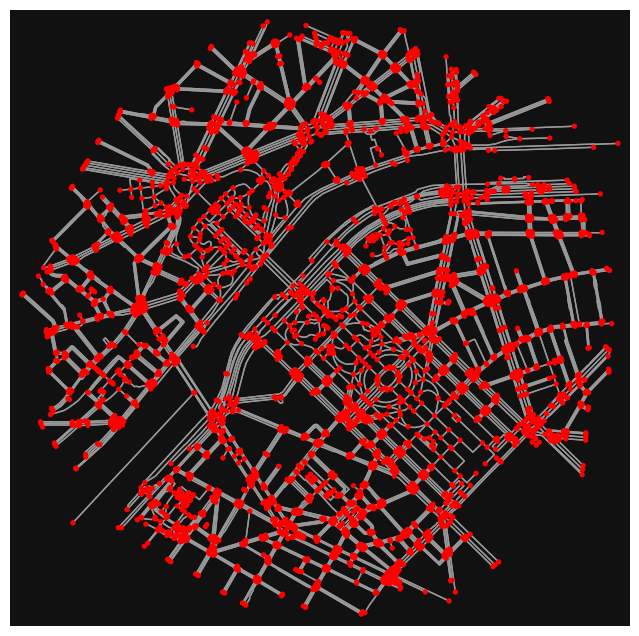

In [19]:
fig, ax = ox.plot_graph(g_eiffel, node_color="r")

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


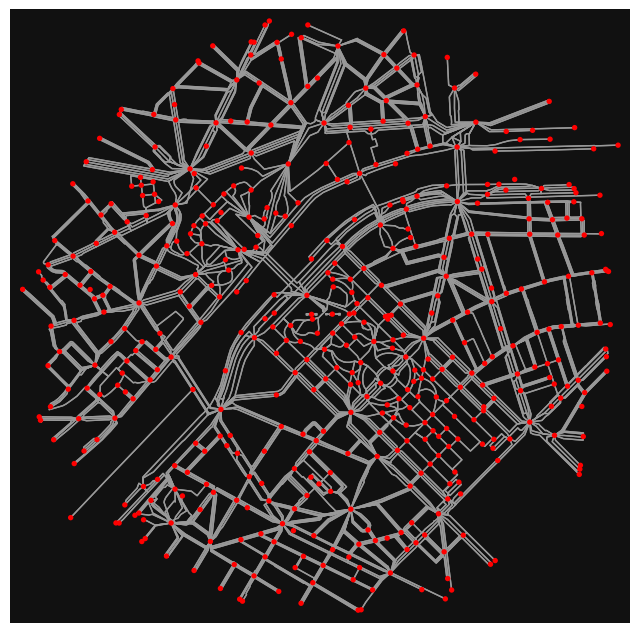

In [20]:
# group together intersections that are globally the same node
g_proj = ox.project_graph(g_eiffel)
g_eiffel2 = ox.consolidate_intersections(g_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
fig, ax = ox.plot_graph(g_eiffel2, node_color="r")

You can see on the Trocadero that we've gone from a circular square with several nodes to a single node for the whole square, a simpler (and undoubtedly effective) representation of the Parisian road network.

In [21]:
# whether or not to use the simplified network
g_eiffel2 = ox.project_graph(g_eiffel2, to_crs="WGS-84")

g_eiffel = g_eiffel2

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Carte du réseau piéton à moins d'un kilomètre de la tour Eiffel

In [22]:
# interactive map
# voir : https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.folium.plot_graph_folium 
map_eiffel = ox.plot_graph_folium(g_eiffel, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25,tiles="OpenStreetMap")
map_eiffel

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-22-ea0937ba1732>:3: UserWarning: The `folium` module has been deprecated and will be removed in a future release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  map_eiffel = ox.plot_graph_folium(g_eiffel, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25,tiles="OpenStreetMap")


## Points of interest data (more general category: geometries)

---

### Data recovery for leisure poi

In [23]:
#tags = {"leisure": True, "amenity":True, "shop":True} # Works as a union, not an intersection
tags = {"amenity":["restaurant", "cafe","bar","ice_cream","fast_food","pub","food_court","biergarten"]}
# See: https://wiki.openstreetmap.org/wiki/FR:%C3%89l%C3%A9ments_cartographiques 
# The most relevant category for us is probably: 
# https://wiki.openstreetmap.org/wiki/FR:%C3%89l%C3%A9ments_cartographiques#Consommation
gdf_pois_eiffel = ox.geometries_from_place(tour_eiffel, tags, buffer_dist=1000)
# Some places (like a city) have an associated polygon, so we can retrieve the POIs without specifying a distance
gdf_pois_eiffel["center"] = gdf_pois_eiffel.centroid
# Each row can be either a polygon (e.g., for the Champ de Mars) or a point like a restaurant: we calculate the centroid to have a unique reference
gdf_pois_eiffel.head()
# This time, we directly retrieve a GeoDataFrame

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-23-a5669f3f5084>:6: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  gdf_pois_eiffel = ox.geometries_from_place(tour_eiffel, tags, buffer_dist=1000)
/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/osmnx/geometries.py:127: UserWarning: The buffer_dist argument as been deprecated and will be removed in a future release. Buffer your query area directly, if desired.
  return featu

amenity              brewery contact:city  \
element_type osmid                                                     
node         252958952         pub  Frog Natural Blonde        Paris   
             254494167  restaurant                  NaN          NaN   
             254497766  restaurant                  NaN          NaN   
             255060753  restaurant                  NaN          NaN   
             308684349        cafe                  NaN          NaN   

                       contact:housenumber      contact:phone  \
element_type osmid                                              
node         252958952             110 bis  +33 1 47 27 88 88   
             254494167                 NaN                NaN   
             254497766                 NaN                NaN   
             255060753                 NaN                NaN   
             308684349                 NaN                NaN   

                       contact:postcode contact:street  \
element_type osmid                                       
node         252958952            75116  Avenue Kléber   
             254494167              NaN            NaN   
             254497766              NaN            NaN   
             255060753              NaN            NaN   
             308684349              NaN            NaN   

                                                      contact:website  \
element_type osmid                                                      
node         252958952  https://www.frogpubs.com/fr/pub-XVI-paris.php   
             254494167                                            NaN   
             254497766                                            NaN   
             255060753                                            NaN   
             308684349                                            NaN   

                       diet:vegan microbrewery  ... opening_hours:kitchen  \
element_type osmid                              ...                         
node         252958952        yes          yes  ...                   NaN   
             254494167        NaN          NaN  ...                   NaN   
             254497766        NaN          NaN  ...                   NaN   
             255060753        NaN          NaN  ...                   NaN   
             308684349        NaN          NaN  ...                   NaN   

                       branch food nodes name:signed building:levels  \
element_type osmid                                                     
node         252958952    NaN  NaN   NaN         NaN             NaN   
             254494167    NaN  NaN   NaN         NaN             NaN   
             254497766    NaN  NaN   NaN         NaN             NaN   
             255060753    NaN  NaN   NaN         NaN             NaN   
             308684349    NaN  NaN   NaN         NaN             NaN   

                       building:part height layer                    center  
element_type osmid                                                           
node         252958952           NaN    NaN   NaN  POINT (2.28810 48.86469)  
             254494167           NaN    NaN   NaN  POINT (2.30063 48.86003)  
             254497766           NaN    NaN   NaN  POINT (2.30596 48.86042)  
             255060753           NaN    NaN   NaN  POINT (2.28993 48.86509)  
             308684349           NaN    NaN   NaN  POINT (2.30151 48.86091)  

[5 rows x 99 columns]

### Carte interactive des restaurants et lieux de consommation à moins d'un kilomètre à pieds de la Tour Eiffel

In [24]:
"""
It is the classical folium method : you create a list with geometry point values (here gdf_pois_eiffel.center) and fir each 
coordinates, you add a marker. 
"""
tour_eiffel_latlong = [48.857551, 2.29394] #on représente en lat, long (et donc y,x)!!!
map = folium.Map(location=tour_eiffel_latlong, tiles="OpenStreetMap", zoom_start=14)

for poi in gdf_pois_eiffel.iterrows():
    # Place the markers with the popup labels and data
    x , y = (poi[1]['center'].x, poi[1]['center'].y)
    map.add_child(
        folium.Marker(
            location=[y,x],
            popup=
                 "Name: " + str(poi[1]['name']) + "<br>" #here to add name 
                #+ "Leisure: " + str(poi[1]['leisure']) + "<br>" #type 
                + "Amenity: " + str(poi[1]['amenity']) + "<br>" #type 
                + "Coordinates: " + str(y)+', '+str(x)
            ,
        
            icon=folium.Icon(color="blue"),
        )
    )


/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
map

RMQ: We can observe differences compared to the map generated from Geofabrik data when considering all leisure amenities:
- The Tour Eiffel is either not filled (or barely filled) on the OSMnx map.
- Ports are not represented on the Geofabrik map.

Apparently, this comes from the tags and the selection made.

### Lien réseau et POI

Below is an example of calculations between nodes and POIs.

Should we calculate the nearest node for each POI and add an entry in their properties?

In [28]:
print(gros_caillou_xy.x.dtype)
print(gros_caillou_xy.y.dtype)

float64
float64


/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# To link the two, you can retrieve the POI's coords,
# the nearest node in the graph. 
# Example: distance between the Eiffel Tower and the Port du Gros Caillou.
tour_eiffel_xy= pd.DataFrame({'x':[tour_eiffel_latlong[1]],'y':[tour_eiffel_latlong[0]]})
gros_caillou_xy = gdf_pois_eiffel[gdf_pois_eiffel['name'] == 'Port du Gros Caillou']['center']
orig = ox.distance.nearest_nodes(g_eiffel, X=tour_eiffel_xy.x[0], Y=tour_eiffel_xy.y[0])
dest = ox.distance.nearest_nodes(g_eiffel, X=float(gros_caillou_xy.x.astype(float)), Y=float(gros_caillou_xy.y.astype(float)))

# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(g_eiffel, orig, dest, weight="lenght") # on peut aussi mettre travel_time
fig, ax = ox.plot_graph_route(g_eiffel, route, node_size=0)

#voir aussi : https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.shortest_path
# mais on a pas la distance par ex

/Users/yubocai/anaconda3/envs/mlp/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: cannot convert the series to <class 'float'>

Calcul de la distance entre la tour Eiffel et le port du gros caillou

In [ ]:
#calcul de distance
n = len(route)-1
dist_metric = 0
for i in range(n):
    adj = g_eiffel.adj[route[i]]
    dist_metric += adj[route[i+1]][0]['length']
    #adj un dic (avec comme clé tout les noeuds adjacants, donc en autre celui de notre chemin), de dic (comme clé inconnue mais probablement les edges reliés au noeud) 
    # de dic des différentes propriétés de cette edge
dist_metric #correspond à un peu au calcul effectué à la main sur google maps

1597.1639999999998

# Utilisation des données de geofabrik

In [ ]:
# Téléchargement :
# https://download.geofabrik.de/europe/france/ile-de-france.html
data_folder = "./data/"
zipname = "Ile-de-France-Geofabrik-free"
geofabrik_idf_shp_link = "https://download.geofabrik.de/europe/france/ile-de-france-latest-free.shp.zip"
r = requests.get(geofabrik_idf_shp_link)

open(data_folder+zipname+".zip",'wb').write(r.content)

In [ ]:
# unzip des données en provenance de :
geofabrik_folder = data_folder+zipname+"/"
datafile_name = 'gis_osm_pois_a_free_1.shp'
dataextensions_unzip = ['.shp','.shx','.cpg','.dbf','.prj']
with ZipFile(data_folder+zipname+".zip") as myzip:
    for ext in dataextensions_unzip :
        myzip.extract(datafile_name[:-4]+ext, path = geofabrik_folder)

In [ ]:
# ouverture des données
df_pois = gpd.read_file(geofabrik_folder+datafile_name)

# note : pois stands for points of interests

In [ ]:
"""
I Only keep leisure and some shops and markets (see documentation : https://download.geofabrik.de/osm-data-in-gis-formats-free.pdf) 
"""

df_pois  = df_pois[(df_pois["code"] >= 2201) 
                   & (df_pois["code"] <= 2706)]

In [ ]:

df_pois = df_pois.reset_index(drop = True) #I restart index  

In [ ]:
df_pois 

osm_id  code   fclass                    name  \
0         4083189  2204     park           Parc de Bercy   
1         4208595  2204     park           Champ de Mars   
2         4221369  2204     park      Jardin des Plantes   
3         4263203  2204     park  Jardin du Palais Royal   
4         4410586  2204     park                    None   
...           ...   ...      ...                     ...   
46023  1112119036  2421  shelter                    None   
46024  1112121750  2421  shelter                    None   
46025  1112127658  2421  shelter                    None   
46026  1112127661  2421  shelter                    None   
46027  1112130356  2421  shelter                    None   

                                                geometry  
0      POLYGON ((2.37807 48.83739, 2.37812 48.83741, ...  
1      POLYGON ((2.29187 48.85771, 2.29230 48.85801, ...  
2      POLYGON ((2.35510 48.84374, 2.35511 48.84375, ...  
3      POLYGON ((2.33672 48.86417, 2.33674 48.86422, ...  
4      POLYGON ((2.20680 48.87370, 2.20770 48.87409, ...  
...                                                  ...  
46023  POLYGON ((2.46203 48.81455, 2.46204 48.81456, ...  
46024  POLYGON ((2.41404 48.82155, 2.41410 48.82157, ...  
46025  POLYGON ((2.41030 48.82361, 2.41032 48.82362, ...  
46026  POLYGON ((2.40987 48.82409, 2.40989 48.82410, ...  
46027  POLYGON ((2.45191 48.84708, 2.45192 48.84711, ...  

[46028 rows x 5 columns]

In [ ]:
"""
I use folium to create an interative map centered in Eiffel Tower
"""


map = folium.Map(location=[48.857551, 2.29394], tiles="OpenStreetMap", zoom_start=14)
map

In [ ]:
"""
I use gpd.centroid to have polygon centers (more easy to manipulate) 
"""
# geometry (active) column
df_pois = df_pois.to_crs(epsg=4326)
df_pois['center'] = df_pois.centroid
# Centroid column
df_pois["center"] = df_pois['center'].to_crs(epsg=4326)

df_pois.head()

C:\Users\leopo\AppData\Local\Temp\ipykernel_19944\2415629637.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_pois['center'] = df_pois.centroid


osm_id  code fclass                    name  \
0  4083189  2204   park           Parc de Bercy   
1  4208595  2204   park           Champ de Mars   
2  4221369  2204   park      Jardin des Plantes   
3  4263203  2204   park  Jardin du Palais Royal   
4  4410586  2204   park                    None   

                                            geometry                    center  
0  POLYGON ((2.37807 48.83739, 2.37812 48.83741, ...  POINT (2.38212 48.83549)  
1  POLYGON ((2.29187 48.85771, 2.29230 48.85801, ...  POINT (2.29792 48.85605)  
2  POLYGON ((2.35510 48.84374, 2.35511 48.84375, ...  POINT (2.35926 48.84334)  
3  POLYGON ((2.33672 48.86417, 2.33674 48.86422, ...  POINT (2.33781 48.86501)  
4  POLYGON ((2.20680 48.87370, 2.20770 48.87409, ...  POINT (2.20915 48.87240)

In [ ]:
"""
I filter a zone near Eiffel Tower. 
"""

gdf_pois = pd.concat([df_pois, df_pois.bounds], axis=1) #I use gpd bounds to have coordonnees in two columns and not only in Point(x,y) 

gdf_pois_eiffel = gdf_pois[(gdf_pois["minx"] >= 2.287592 ) &
        (gdf_pois["minx"] <= 2.314801) &
         (gdf_pois["miny"] >= 48.847194) &
        (gdf_pois["miny"] <= 48.866217)]

gdf_pois_eiffel = gdf_pois_eiffel.reset_index(drop = True) #reset index. 

In [ ]:
"""
It is the classical folium method : you create a list with geometry point values (here gdf_pois_eiffel.center) and fir each 
coordinates, you add a marker. 
"""

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf_pois_eiffel.center] 


i = 0
for coordinates in geo_df_list:
    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            popup=
                 "Name: " + str(gdf_pois_eiffel.name[i]) + "<br>" #here to add name 
                + "type: " + str(gdf_pois_eiffel.fclass[i]) + "<br>" #type 
                + "Coordinates: " + str(geo_df_list[i])
            ,
        
            icon=folium.Icon(color="blue"),
        )
    )
    i = i + 1

In [ ]:
map